# Netflix Recommender System

**Problem Statement**

Netflix provided a lot of anonymous rating data, and a prediction accuracy bar that is 10% better than what Cinematch can do on the same training data set. (Accuracy is a measurement of how closely predicted ratings of movies match subsequent actual ratings.)

**Objectives**

-  Predict Rating of a item that the user havent seen yet
-  Minimise Difference between Predicted and Actual Rating

**Data Overview**

In [ ]:
import os

for f in os.listdir('train/'):
    print(f)

combined_data_1.txt
combined_data_2.txt
combined_data_3.txt
combined_data_4.txt
movie_titles.csv


The first line of each file [combined_data_1.txt, combined_data_2.txt, combined_data_3.txt, combined_data_4.txt] contains the movie id followed by a colon. Each subsequent line in the file corresponds to a rating from a customer and its date in the following format:
CustomerID,Rating,Date


MovieIDs range from 1 to 17770 sequentially.
CustomerIDs range from 1 to 2649429, with gaps. There are 480189 users.
Ratings are on a five star (integral) scale from 1 to 5.
Dates have the format YYYY-MM-DD

**Type of ML Problem**

-  For a given movie and user we need to predict the rating would be given by him/her to the movie.The given problem is a Recommendation problem 
-  It can also seen as a Regression problem

**Perfomance Metrics**

-  Mean Absolute Percentage
-  Root Mean Square Error


***

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random
from datetime import datetime

## Exploratory Data Analysis
### Preprocessing
**Merging files**

In [ ]:
files=os.listdir('data/')

if not os.path.isfile('data.csv'):
    data = open('data.csv', mode='w')
    
    row =[]

    for file in files:
        with open('data/'+file) as f:
            for line in f: 
                del row[:]
                line = line.strip()
                if line.endswith(':'):
                    # All below are ratings for this movie, until another movie appears.
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        
    data.close()

In [ ]:
df = pd.read_csv('data.csv', sep=',',names=['movie', 'user','rating','date'])
df.date = pd.to_datetime(df.date)
# we are arranging the ratings according to time as this is temporal data
df.sort_values(by='date', inplace=True)

In [ ]:
df.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


In [ ]:
df.describe()

,movie,user,rating
count,1.004805e+08,1.004805e+08,1.004805e+08
mean,9.070915e+03,1.322489e+06,3.604290e+00
std,5.131891e+03,7.645368e+05,1.085219e+00
min,1.000000e+00,6.000000e+00,1.000000e+00
25%,4.677000e+03,6.611980e+05,3.000000e+00
50%,9.051000e+03,1.319012e+06,4.000000e+00
75%,1.363500e+04,1.984455e+06,4.000000e+00
max,1.777000e+04,2.649429e+06,5.000000e+00


**Checking for Null Values and Duplicates**

In [ ]:
print("No of Nan values in our dataframe : ", sum(df.isnull().any()))

No of Nan values in our dataframe :  0


In [ ]:
dups = sum(df.duplicated(['movie','user','rating']))
print("There are {} duplicate rating entries in the data".format(dups))

**Basic Statistics on Dataset**

In [ ]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.user)))
print("Total No of movies  :", len(np.unique(df.movie)))

Total data 
--------------------------------------------------

Total no of ratings : 100480507
Total No of Users   : 480189
Total No of movies  : 17770


## Splitting into Test Train


We Split Data Temporally

In [ ]:
df.iloc[:int(df.shape[0]*0.80)].to_csv("train.csv", index=False)
df.iloc[int(df.shape[0]*0.80):].to_csv("test.csv", index=False)

In [ ]:
train_df = pd.read_csv("train.csv", parse_dates=['date'])
test_df = pd.read_csv("test.csv")

### Basic Statistics

**Train Data**

In [ ]:
print("Train data ")
print("-"*50)
print("\nTotal no of ratings :",train_df.shape[0])
print("Total No of Users   :", len(np.unique(train_df.user)))
print("Total No of movies  :", len(np.unique(train_df.movie)))

Train data 
--------------------------------------------------

Total no of ratings : 80384405
Total No of Users   : 405041
Total No of movies  : 17424


**Test Data**

In [ ]:
print("Test data ")
print("-"*50)
print("\nTotal no of ratings :",test_df.shape[0])
print("Total No of Users   :", len(np.unique(test_df.user)))
print("Total No of movies  :", len(np.unique(test_df.movie)))

Test data 
--------------------------------------------------

Total no of ratings : 20096102
Total No of Users   : 349312
Total No of movies  : 17757


## EDA on Train Data

In [ ]:
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

**Distribution of Ratings**

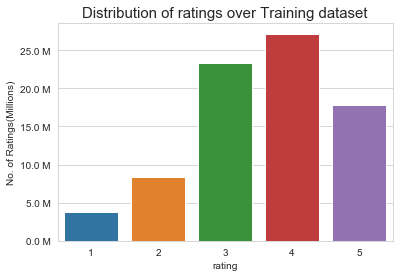

In [ ]:
fig, ax = plt.subplots()
plt.title('Distribution of ratings over Training dataset', fontsize=15)
sns.countplot(train_df.rating)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Millions)')

plt.show()

In [ ]:
train_df['day_of_week'] = train_df.date.dt.weekday_name

In [ ]:
train_df.head()

,movie,user,rating,date,day_of_week
0,10341,510180,4,1999-11-11,Thursday
1,1798,510180,5,1999-11-11,Thursday
2,10774,510180,3,1999-11-11,Thursday
3,8651,510180,2,1999-11-11,Thursday
4,14660,510180,2,1999-11-11,Thursday


**Number of Ratings per Month**

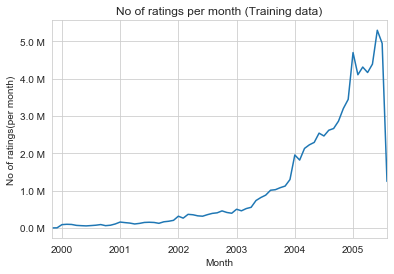

In [ ]:
ax = train_df.resample('m', on='date')['rating'].count().plot()
ax.set_title('No of ratings per month (Training data)')
plt.xlabel('Month')
plt.ylabel('No of ratings(per month)')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

**Analysing Ratings per User**

In [ ]:
nrated_movies_users= train_df.groupby(by='user')['rating'].count().sort_values(ascending=False)

In [ ]:
nrated_movies_users.head()

user
305344     17112
2439493    15896
387418     15402
1639792     9767
1461435     9447
Name: rating, dtype: int64

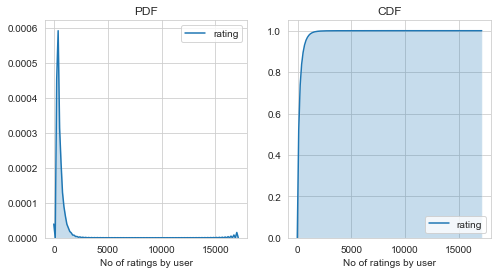

In [ ]:
fig = plt.figure(figsize=plt.figaspect(.5))
ax1 = plt.subplot(121)
sns.kdeplot(nrated_movies_users, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(nrated_movies_users, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')

plt.show()

**Number of Ratings per User are Skewed**



In [ ]:
nrated_movies_users.describe()

count    405041.000000
mean        198.459921
std         290.793238
min           1.000000
25%          34.000000
50%          89.000000
75%         245.000000
max       17112.000000
Name: rating, dtype: float64

In [ ]:
quantiles = nrated_movies_users.quantile(np.arange(0,1.01,0.01), interpolation='higher')

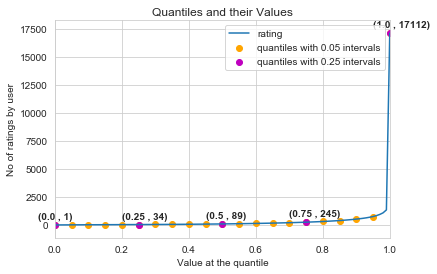

In [ ]:
plt.title("Quantiles and their Values")
quantiles.plot()
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')


for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500),fontweight='bold')
plt.show()

In [ ]:
quantiles[::5]

0.00        1
0.05        7
0.10       15
0.15       21
0.20       27
0.25       34
0.30       41
0.35       50
0.40       60
0.45       73
0.50       89
0.55      109
0.60      133
0.65      163
0.70      199
0.75      245
0.80      307
0.85      392
0.90      520
0.95      749
1.00    17112
Name: rating, dtype: int64

In [ ]:
print('No of ratings at last 5 percentile :',(sum(nrated_movies_users>= 749)))

No of ratings at last 5 percentile : 20305


**Analysing Number of Ratings per Movie**

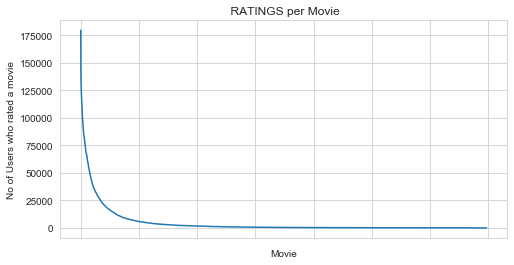

In [ ]:
nrated_per_movie = train_df.groupby(by='movie')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(nrated_per_movie.values)
plt.title(' Ratings per Movie')
plt.xlabel('Movie')
plt.ylabel('No of Users who rated a movie')
ax.set_xticklabels([])

plt.show()

**Observations**

- It is very skewed.. just like nunmber of ratings given per user.
- There are some movies (which are very popular) which are rated by huge number of users.
- But most of the movies(like 90%) got some hundereds of ratings

**Number of Ratings on each Day**

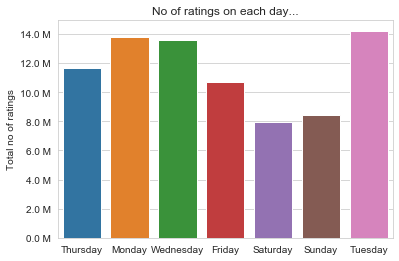

In [ ]:
fig, ax = plt.subplots()
sns.countplot(x='day_of_week', data=train_df, ax=ax)
plt.title('No of ratings on each day...')
plt.ylabel('Total no of ratings')
plt.xlabel('')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

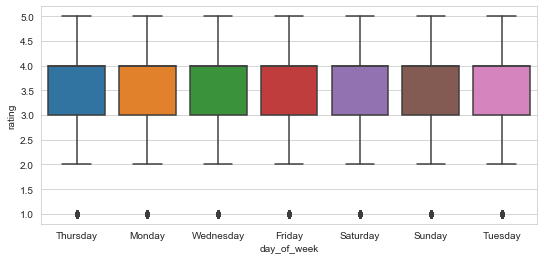

In [ ]:
fig = plt.figure(figsize=plt.figaspect(.45))
sns.boxplot(y='rating', x='day_of_week', data=train_df)
plt.show()

In [ ]:
avg_week_df = train_df.groupby(by=['day_of_week'])['rating'].mean()
print(" Average ratings")
print("-"*30)
print(avg_week_df)
print("\n")

 Average ratings
------------------------------
day_of_week
Friday       3.585274
Monday       3.577250
Saturday     3.591791
Sunday       3.594144
Thursday     3.582463
Tuesday      3.574438
Wednesday    3.583751
Name: rating, dtype: float64




### Creating Sparse Matrix from DataFrame

**Train**

In [ ]:
train_sparse_matrix = sparse.csr_matrix((train_df.rating.values, (train_df.user.values,train_df.movie.values)),)
sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)

In [ ]:
train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
print('Train Matrix shape is : (user, movie) : ',train_sparse_matrix.shape)

Train Matrix shape is : (user, movie) :  (2649430, 17771)


In [ ]:
us,mv = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()

print("Sparsity Of Train matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Train matrix : 99.8292709259195 % 


***

**Test**

In [ ]:
test_sparse_matrix = sparse.csr_matrix((test_df.rating.values, (test_df.user.values,test_df.movie.values)),)
sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)

In [ ]:
test_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')
print('Test Matrix shape is : (user, movie) : ',test_sparse_matrix.shape)

Test Matrix shape is : (user, movie) :  (2649430, 17771)


In [ ]:
us,mv = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()

print("Sparsity Of Test matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Test matrix : 99.95731772988694 % 


In [ ]:
def get_averages(sparse_m,flag):
    #movie,user 0,1
    
    sumRatings=sparse_m.sum(axis=flag).A1
    rated = sparse_m!=0
    numRatings=rated.sum(axis=flag).A1
    
    u,m = sparse_m.shape
    x=u if flag is 1 else m 
    avgRatings={ i : sumRatings[i]/numRatings[i] for i in range(x) if numRatings[i] !=0}
    
    return avgRatings

**Global Average of Movie Ratings**

In [ ]:
train_averages ={}
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
print('Global Ratings of Movie Ratings :',train_global_average)

Global Ratings of Movie Ratings : 3.582890686321557


**Average Ratings per User**

In [ ]:
train_averages['user'] = get_averages(train_sparse_matrix,flag=1)
for i in range(5):
    print('\n Average rating of user ',i,' is : ',list(train_averages['user'].values())[i])


 Average rating of user  0  is :  3.5160550458715596

 Average rating of user  1  is :  3.992957746478873

 Average rating of user  2  is :  3.3781094527363185

 Average rating of user  3  is :  3.5

 Average rating of user  4  is :  3.787878787878788


**Average Ratings per Movie**

In [ ]:
train_averages['movies'] = get_averages(train_sparse_matrix,flag=0)
for i in range(5):
    print('\n Average rating of user ',i,' is : ',list(train_averages['movies'].values())[i])


 Average rating of user  0  is :  3.7189873417721517

 Average rating of user  1  is :  3.6923076923076925

 Average rating of user  2  is :  3.6474181010549693

 Average rating of user  3  is :  2.763358778625954

 Average rating of user  4  is :  4.036817102137767


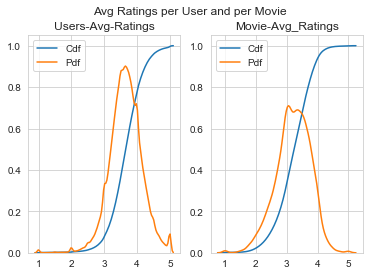

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.suptitle('Avg Ratings per User and per Movie')

ax1.set_title('Users-Avg-Ratings')
user_averages = [v for v in train_averages['user'].values()]
sns.distplot(user_averages, ax=ax1, hist=False,kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(user_averages, ax=ax1, hist=False,label='Pdf')

ax2.set_title('Movie-Avg_Ratings')
movie_avg=[m for m in train_averages['movies'].values()]
sns.distplot(movie_avg,ax=ax2,hist=False,kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(movie_avg,ax=ax2,hist=False,label='Pdf')

plt.show()

***

## Cold start problem
When we encounter new 'Users' or 'Movies'

**Total Users in Dataset : 480189**


In [ ]:
t_usr=len(train_averages['user'].values())
n_usr=480189-t_usr
print('Number of Users in train data :',t_usr)
print('Number of Users that are not in train data :{} ({}%)'.format(n_usr,np.round(n_usr/t_usr*100)))

Number of Users in train data : 405041
Number of Users that are not in train data :75148 (19.0%)


**Total Movies in Dataset : 17770**

In [ ]:
t_m=len(train_averages['movies'].values())
n_m=17770-t_m
print('Number of Users in train data :',t_m)
print('Number of Users that are not in train data :{} ({}%)'.format(n_m,np.round(n_m/t_m*100)))

Number of Users in train data : 17424
Number of Users that are not in train data :346 (2.0%)


***

## Computing Similarity Matrix

### 1. User-User Similarity Matrix

**Calculating for all 17K Dimensions**

In [ ]:
def user_similarity(sparse_matrix,top=50,vrows= 10):
    numusers,_ = sparse_matrix.shape
    row_ind,col_ind = sparse_matrix.nonzero()
    row_ind=sorted(set(row_ind))
    time_taken =[]
    
    rows, cols, data = [],[],[]
    print("Computing top",top,"Similarities for each user")
    start = datetime.now()
    t = 0
    
    for row in row_ind[:top]:
        t+=1
        prev=datetime.now()
        
        #Getting similarity with all users
        sim=cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
        
        #getting only top values
        sim_ind=sim.argsort()[-top:]
        sim_vals=sim[sim_ind]
        
        #add to rows cols data for sparse matrix
        rows.extend([row]*top)
        cols.extend(sim_ind)
        data.extend(sim_vals)
        
        time_taken.append(datetime.now().timestamp() - prev.timestamp())
        
        if(t%vrows==0):print('Calculated for {} users time elapsed  {}'.format(t,datetime.now()-start))
    print('Creating Sparse Matrix')       
    plt.plot(time_taken, label = 'Time taken for each User')
    plt.plot(np.cumsum(time_taken), label='Total time')
    plt.legend(loc='best')
    plt.xlabel('User')
    plt.ylabel('Time (seconds)')
    plt.show()
    
    return sparse.csr_matrix((data, (rows, cols)), shape=(numusers, numusers))

Computing top 50 Similarities for each user
Calculated for 10 users time elapsed  0:00:33.485571
Calculated for 20 users time elapsed  0:01:06.151391
Calculated for 30 users time elapsed  0:01:40.402787
Calculated for 40 users time elapsed  0:02:14.325154
Calculated for 50 users time elapsed  0:02:46.409568
Creating Sparse Matrix


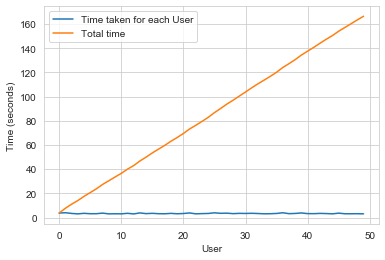

----------------------------------------------------------------------------------------------------
Time taken : 0:02:58.408415


In [ ]:
start = datetime.now()
user_user = user_similarity(train_sparse_matrix)
print("-"*100)
print("Time taken :",datetime.now()-start)

**Each user takes around 3.34 secs we have 405041×3.34 = 135283.94 s =22547.2823 min = 375.5 hours**

**We will Reduce the Dimensionality of vector using SVD 17k to 500**

In [ ]:
%%time

netflix_svd = TruncatedSVD(n_components=500, algorithm='randomized', random_state=15)
trunc_svd = netflix_svd.fit_transform(train_sparse_matrix)

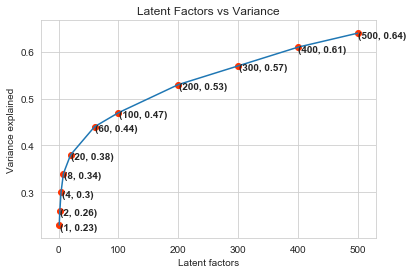

In [ ]:
laten={1:0.23,2:0.26,4:0.3,8:0.34,20:0.38,60:0.44,100:0.47,200:0.53,300:0.57,400:0.61,500:0.64}
plt.plot(*zip(*sorted(laten.items())))
plt.title('Latent Factors vs Variance')
plt.xlabel('Latent factors')
plt.ylabel('Variance explained')
plt.scatter(x = [i for i in laten.keys()], y =[i for i in laten.values()], c='#ff3300')

for i in laten.keys():
    plt.annotate(s ="({}, {})".format(i,  np.round(laten[i], 2)), xy=(i-1, laten[i]),
                xytext = ( i+1, laten[i] - 0.01), fontweight='bold')
plt.show()


**Observations :**
- With increasing Latent Factors variance explained also increases
- 500 Latent Factors explain 64% variance.

In [ ]:
#projecting to 500 dims
trunc_matrix = train_sparse_matrix.dot(netflix_svd.components_.T)

In [ ]:
if not os.path.isfile('trunc_sparse_matrix.npz'):
    trunc_sparse_matrix = sparse.csr_matrix(trunc_matrix)
    sparse.save_npz('trunc_sparse_matrix', trunc_sparse_matrix) 

In [ ]:
trunc_sparse_matrix = sparse.load_npz('trunc_sparse_matrix.npz')

In [ ]:
trunc_sparse_matrix.shape

(2649430, 500)

Computing top 50 Similarities for each user
Calculated for 10 users time elapsed  0:00:55.782314
Calculated for 20 users time elapsed  0:01:50.449898
Calculated for 30 users time elapsed  0:02:46.719958
Calculated for 40 users time elapsed  0:03:42.663770
Calculated for 50 users time elapsed  0:04:40.471972
Creating Sparse Matrix


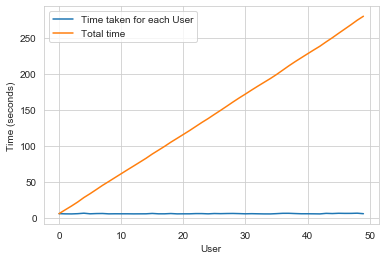

Time Taken : 0:05:01.716094


In [ ]:
start = datetime.now()
truncated_user_user = user_similarity(trunc_sparse_matrix)
print("Time Taken :",datetime.now()-start)

- It takes 5.5s for a single user
- Total time taken for all users =  405041 * 5.5 =2227725.5s = 37128.75 mins = 618.81hrs



**Computing user similarity at runtime**

- We take a Binary vector showing if user values have been computed earlier or not
- We compute only top 1000 similar users to a given user and save it and mark it


### 2. Movie Movie Similarity Matrix

In [ ]:
%%time
movie_movie = cosine_similarity(X=train_sparse_matrix.T, dense_output=False)
sparse.save_npz("mov_mov_sim.npz", movie_movie)

Wall time: 7min 30s


In [ ]:
mov_mov = sparse.load_npz("mov_mov_sim.npz")

In [ ]:
mov_mov.shape

(17771, 17771)

#### Finding similar Movies using Similarity Matrix

In [ ]:
c=['movie_id', 'year_of_release', 'title']
movie_titles = pd.read_csv("train/movie_titles.csv", sep=',', header = None,names=c,index_col = 'movie_id', encoding = "ISO-8859-1")
movie_titles.head()

,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [ ]:
mv_id = 1023

print("\nMovie : ",movie_titles.loc[mv_id].values[1])

print("\nIt has {} Ratings from users.".format(train_sparse_matrix[:,mv_id].getnnz()))

print("\nWe have {} movies which are simila rto this  and we will get only top".format(mov_mov[:,mv_id].getnnz()))


Movie :  Sesame Street: Elmo Saves Christmas

It has 344 Ratings from users.

We have 17280 movies which are simila rto this  and we will get only top


In [ ]:
similarities = mov_mov[mv_id].toarray().ravel()
similar_indices = similarities.argsort()[::-1][1:]
movie_titles.loc[similar_indices[:10]]

,year_of_release,title
movie_id,,
12426,2000.0,Cinderelmo: Sesame Street
6671,1998.0,Sesame Street: Elmopalooza!
5558,1993.0,Sesame Street's 25th Birthday: A Musical Celeb...
1629,1997.0,Sesame Street: 1-2-3
10824,1995.0,Sesame Street: Do the Alphabet
6853,1991.0,Sesame Street: Elmo's Sing-Along Guessing Game
3677,2000.0,Sesame Street: Let's Make Music
2791,1999.0,The Adventures of Elmo in Grouchland
15486,2001.0,Sesame Street: Elmo's World: Wild Wild West


**Similarily we can get similar users**

***

## Machine Learning Models

**Sampling data**

In [ ]:
def sample_data(sparse_matrix,numU,numM):
    row_ind,col_ind,rating=sparse.find(sparse_matrix)
    users=np.unique(row_ind)
    movies=np.unique(col_ind)
    
    np.random.seed(15)
    sample_users = np.random.choice(users, numU, replace=False)
    sample_movies = np.random.choice(movies,numM, replace=False)
    # get the boolean mask or these sampled_items in originl row/col_inds..
    mask = np.logical_and( np.isin(row_ind, sample_users),np.isin(col_ind, sample_movies) )
    
    sample_sparse_matrix = sparse.csr_matrix((rating[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))
   
    print("Sampled Matrix : (users, movies) -- ({} {})".format(len(sample_users), len(sample_movies)))
    print("Sampled Matrix : Ratings --", format(rating[mask].shape[0]))

    
    # save it into disk
    sparse.save_npz('samplesparse.npz', sample_sparse_matrix)
    return sample_sparse_matrix

In [ ]:
sample_train = sample_data(train_sparse_matrix,10000,1000)

Sampled Matrix : (users, movies) -- (10000 1000)
Sampled Matrix : Ratings -- 129286


In [ ]:
sample_test = sample_data(test_sparse_matrix,5000,500)

Sampled Matrix : (users, movies) -- (5000 500)
Sampled Matrix : Ratings -- 7333


### Analysing Train Data

In [ ]:
sample_train_averages={}
global_average = sample_train.sum()/sample_train.count_nonzero()
sample_train_averages['global'] = global_average

**Global Average Ratings of Movies**

In [ ]:
print('Global Ratings: ',global_average)

Global Ratings:  3.581679377504138


**Average Ratings of User**

In [ ]:
sample_train_averages['user'] = get_averages(sample_train,flag=1)
for i in range(5):
    print('\n Average rating of user ',i,' is : ',list(sample_train_averages['user'].values())[i])


 Average rating of user  0  is :  4.0

 Average rating of user  1  is :  3.6666666666666665

 Average rating of user  2  is :  4.0

 Average rating of user  3  is :  2.0

 Average rating of user  4  is :  5.0


**Average Ratings of Movie**

In [ ]:
sample_train_averages['movie'] = get_averages(sample_train,flag=0)
for i in range(5):
    print('\n Average rating of movie ',i,' is : ',list(sample_train_averages['movie'].values())[i])


 Average rating of movie  0  is :  4.092436974789916

 Average rating of movie  1  is :  2.5

 Average rating of movie  2  is :  5.0

 Average rating of movie  3  is :  3.8840579710144927

 Average rating of movie  4  is :  2.8


### Featurising Data for Regression Problem

#### Train Data

In [ ]:
ut, mt, rt = sparse.find(sample_train)

In [ ]:
#f1 : Similar users rating of this movie : find similar users ---> for each user find rating of this movie
#f2 : Similar movies rated by this user : find similar movies --> for each movie find ratings

start=datetime.now()

if os.path.isfile('featurised_data_train.csv'):
    print('File is Present.')
else:
    with open('featurised_data_train.csv','w') as f :
        #for each line
        for u,m,r in zip(ut,mt,rt):
            #f1 -> Find similar users
            user_sim = cosine_similarity(sample_train[u],sample_train).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:]
            #-> For each user find rating of this movie
            top_ratings = sample_train[top_sim_users,m].toarray().ravel()
            #-> Reducing to top 5
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_averages['movie'][m]]*(5 - len(top_sim_users_ratings)))
            
            #f2 -> find similar movies
            movi_sim=cosine_similarity(sample_train[m],sample_train).ravel()
            top_sim_mov=movi_sim.argsort()[::-1][1:]
            top_ratings=sample_train[top_sim_mov,u].toarray().ravel()
            top_sim_mov_usr=list(top_ratings[top_ratings!=0][:5])
            top_sim_mov_usr.extend([sample_train['user'][u]]*(5-len(top_sim_mov_usr)))
            
            row=[]
            row.append(u)
            row.append(m)
            row.extend(top_sim_users_ratings)
            row.extend(top_sim_mov_usr)
            row.append(sample_train_averages['user'][u])
            row.append(sample_train_averages['movie'][m])
            row.append(rating)
            
            f.write(','.join(map(str, row)))
            f.write('\n')

In [6]:
f_train = pd.read_csv('featurised_data_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
f_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3
2,99865,33,3.581679,5.0,5.0,4.0,5.0,3.0,5.0,4.0,4.0,5.0,4.0,3.714286,4.092437,5
3,101620,33,3.581679,2.0,3.0,5.0,5.0,4.0,4.0,3.0,3.0,4.0,5.0,3.584416,4.092437,5
4,112974,33,3.581679,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,3.0,3.750000,4.092437,5


### Features
- GAvg : Average rating of all the ratings
- Similar users rating of this movie:
    - sur1, sur2, sur3, sur4, sur5 ( top 5 similar users who rated that movie)
- Similar movies rated by this user:
     - smr1, smr2, smr3, smr4, smr5 ( top 5 similar movies rated by this user)
- UAvg : User's Average rating
- MAvg : Average rating of this movie
- rating : Rating of this movie by this user.


#### Featurising Test Data

In [ ]:
ut, mt, rt = sparse.find(sample_test)

In [ ]:
#f1 : Similar users rating of this movie : find similar users ---> for each user find rating of this movie
#f2 : Similar movies rated by this user : find similar movies --> for each movie find ratings

start=datetime.now()

if os.path.isfile('featurised_data_test.csv'):
    print('File is Present.')
else:
    with open('featurised_data_test','w') as f :
        #for each line
        for u,m,r in zip(ut,mt,rt):
            try:
            #f1 -> Find similar users
                user_sim = cosine_similarity(sample_train[u],sample_train).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:]
                top_ratings = sample_train[top_sim_users,m].toarray().ravel()
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][m]]*(5 - len(top_sim_users_ratings)))
            #New Movie/User
            except(KeyError,IndexError):
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
            
                
            
            #f2 -> find similar movies
            try:
                movi_sim=cosine_similarity(sample_train[m],sample_train).ravel()
                top_sim_mov=movi_sim.argsort()[::-1][1:]
                top_ratings=sample_train[top_sim_mov,u].toarray().ravel()
                top_sim_mov_usr=list(top_ratings[top_ratings!=0][:5])
                top_sim_mov_usr.extend([sample_train['user'][u]]*(5-len(top_sim_mov_usr)))
            except(KeyError,IndexError):
                top_sim_mov_usr.extend([sample_train_averages['global']]*(5 - len(top_sim_mov_usr)))
                
            
            row=[]
            row.append(u)
            row.append(m)
            row.extend(top_sim_users_ratings)
            row.extend(top_sim_mov_usr)
            row.append(sample_train_averages['user'][u])
            row.append(sample_train_averages['movie'][m])
            row.append(rating)
            
            f.write(','.join(map(str, row)))
            f.write('\n')

In [7]:
f_test = pd.read_csv('featurised_data_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'MAvg', 'rating'], header=None)
f_test.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4
2,1737912,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3
3,1849204,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4
4,28572,111,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,1


### Getting Data Ready for Surprise Models

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('gdrive/My Drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!pip install surprise

In [ ]:
from surprise import Reader, Dataset

In [ ]:
reader = Reader(rating_scale=(1,5))
train_data = Dataset.load_from_df(f_train[['user', 'movie', 'rating']], reader)
trainset = train_data.build_full_trainset() 

In [ ]:
testset = list(zip(f_test.user.values,f_test.movie.values,f_test.rating.values))

### Helper Functions for Models
#### Xgboost

In [ ]:
def error_metrics(true,pred):
    rmse = np.sqrt(np.mean([ (true[i] - pred[i])**2 for i in range(len(pred)) ]))
    mape = np.mean(np.abs( (true-pred)/true ))*100
    return rmse, mape

In [ ]:
def run_xgboost(algo,xtrain,ytrain,xtest,ytest):
  train_r,test_r={},{}
  
  algo.fit(x_train, y_train, eval_metric = 'rmse')
  y_train_pred = algo.predict(x_train)
  rmse_train, mape_train =error_metrics(y_train.values, y_train_pred)
  train_r = {'rmse': rmse_train,'mape' : mape_train,'predictions' : y_train_pred}
  
  y_test_pred = algo.predict(x_test)
  rmse_test, mape_test =error_metrics(y_test.values, y_test_pred)
  test_r = {'rmse': rmse_test,'mape' : mape_test,'predictions' : y_test_pred}
  print('\n\n Train --- rmse :{}  mape :{} \n Test --- rmse  :{} mape:{} '.format(rmse_train,mape_train,rmse_test,mape_test))
  return train_r,test_r
  
                    

#### Surprise models

In [ ]:
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

In [ ]:
def get_errors(predictions):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100

In [ ]:
def run_surprise(algo, trainset, testset, verbose=True): 
    train,test={},{}
    
    algo.fit(trainset)
    train_preds = algo.test(trainset.build_testset())
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    train_rmse, train_mape = get_errors(train_preds)
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    

    test_preds = algo.test(testset)
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    test_rmse, test_mape = get_errors(test_preds)
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    print('\n\n Train --- rmse :{}  mape :{} \n Test --- rmse  :{} mape:{} '.format(train['rmse'],train['mape'],test['rmse'],test['mape']))
    return train, test

### XGBoost with 13Features

In [ ]:

import xgboost as xgb

In [ ]:
models_eval_train, models_eval_test={},{}

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \




 Train --- rmse :0.8462861583923632  mape :25.260434292491528 
 Test --- rmse  :1.076373581778953 mape:34.48223172520999 


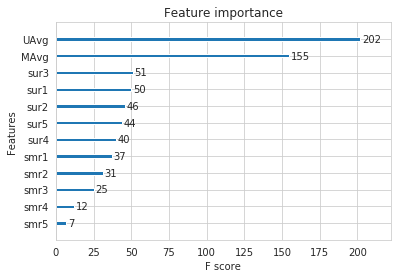

In [35]:
x_train = f_train.drop(['user','movie','rating'], axis=1)
y_train = f_train['rating']

x_test = f_test.drop(['user','movie','rating'], axis=1)
y_test = f_test['rating']


first_xgb = xgb.XGBRegressor(silent=True, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)

models_eval_train['xgb1'] = train_results
models_eval_test['xgb1'] = test_results

xgb.plot_importance(first_xgb)
plt.show()

### Surprise Baseline Model

In [ ]:
from surprise import BaselineOnly

In [40]:
b_o = {'method': 'sgd','learning_rate': .001}
bsl_algo = BaselineOnly(bsl_options=b_o)

bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=True)
models_eval_train['bsl_algo'] = bsl_train_results 
models_eval_test['bsl_algo'] = bsl_test_results

Estimating biases using sgd...


 Train --- rmse :0.9347153928678286  mape :29.389572652358183 
 Test --- rmse  :1.0730330260516174 mape:35.04995544572911 


### XgBoost 13feats + Baseline Predictions

In [ ]:
f_train['bslpr'] = models_eval_train['bsl_algo']['predictions']
f_test['bslpr']=models_eval_test['bsl_algo']['predictions']

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[03:46:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 Train --- rmse :0.8462748657913641  mape :25.260044089775825 
 Test --- rmse  :1.0765603714651855 mape:34.4648051883444 


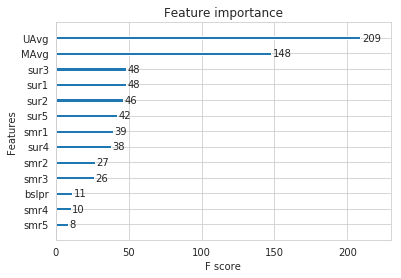

In [43]:
x_train = f_train.drop(['user', 'movie','rating'], axis=1)
y_train = f_train['rating']

x_test = f_test.drop(['user','movie','rating'], axis=1)
y_test = f_test['rating']


xgb_bsl = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(xgb_bsl, x_train, y_train, x_test, y_test)


models_eval_train['xgb_bsl'] = train_results
models_eval_test['xgb_bsl'] = test_results

xgb.plot_importance(xgb_bsl)
plt.show()

### Surprise KNNBaseline predictor

In [ ]:
from surprise import KNNBaseline

In [45]:
so = {'user_based' : True,'name': 'pearson_baseline','shrinkage': 100,'min_support': 2} 

bo = {'method': 'sgd'} 

knn_bsl_u = KNNBaseline(k=40, sim_options = so, bsl_options = bo)
knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset)


models_eval_train['knn_bsl_u'] = knn_bsl_u_train_results 
models_eval_test['knn_bsl_u'] = knn_bsl_u_test_results

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


 Train --- rmse :0.33642097416508826  mape :9.145093375416348 
 Test --- rmse  :1.0726493739667242 mape:35.02094499698424 


### Surprise KNNBaseline with movie movie similarities

In [46]:
so = {'user_based' : False,'name': 'pearson_baseline','shrinkage': 100,'min_support': 2}
bo = {'method': 'sgd'}


knn_bsl_m = KNNBaseline(k=40, sim_options = so, bsl_options = bo)

knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=True)

models_eval_train['knn_bsl_m'] = knn_bsl_m_train_results 
models_eval_test['knn_bsl_m'] = knn_bsl_m_test_results


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


 Train --- rmse :0.32584796251610554  mape :8.447062581998374 
 Test --- rmse  :1.072758832653683 mape:35.02269653015042 


### XGBoost with 13feats + Baseline + KNNBaseline
#### Xgboost + Both KNNs

In [ ]:
f_train['knn_bsl_u'] = models_eval_train['knn_bsl_u']['predictions']
f_train['knn_bsl_m'] = models_eval_train['knn_bsl_m']['predictions']
f_test['knn_bsl_u'] = models_eval_test['knn_bsl_u']['predictions']
f_test['knn_bsl_m'] = models_eval_test['knn_bsl_m']['predictions']

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[04:15:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 Train --- rmse :0.8462124756538578  mape :25.264808220626723 
 Test --- rmse  :1.0767793575625662 mape:34.44745951378593 


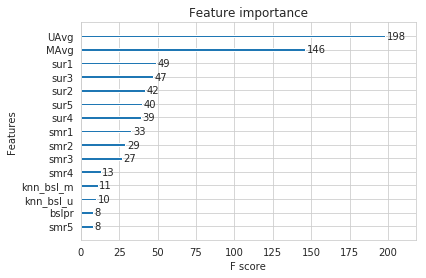

In [53]:
x_train = f_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = f_train['rating']
x_test = f_test.drop(['user','movie','rating'], axis=1)
y_test = f_test['rating']


xgb_knn_bsl = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_knn_bsl, x_train, y_train, x_test, y_test)


models_eval_train['xgb_knn_bsl'] = train_results
models_eval_test['xgb_knn_bsl'] = test_results


xgb.plot_importance(xgb_knn_bsl)
plt.show()

### Matrix Factorization techniques
#### SVD Matrix Factorization User Movie iteraction

In [ ]:
from surprise import SVD

In [50]:
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

models_eval_train['svd'] = svd_train_results 
models_eval_test['svd'] = svd_test_results

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


 Train --- rmse :0.6574721240954099  mape :19.704901088660474 
 Test --- rmse  :1.0726046873826458 mape:35.01953535988152 


#### SVD Matrix Factorization with implicit feedback from user

In [ ]:
from surprise import SVDpp

In [52]:
svdpp = SVDpp(n_factors=50, random_state=15, verbose=True)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

models_eval_train['svdpp'] = svdpp_train_results 
models_eval_test['svdpp'] = svdpp_test_results

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19


 Train --- rmse :0.6032438403305899  mape :17.49285063490268 
 Test --- rmse  :1.0728491944183447 mape:35.03817913919887 


### XgBoost with 13 features + Surprise Baseline + Surprise KNNbaseline + MF Techniques

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[04:17:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 Train --- rmse :0.8462366181909141  mape :25.261350045158785 
 Test --- rmse  :1.0769599573828592 mape:34.431788329400995 


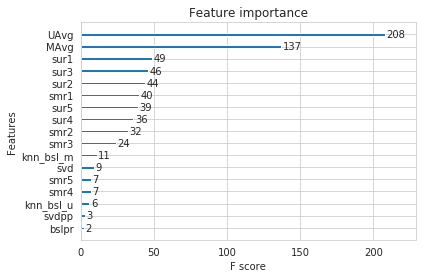

In [55]:
f_train['svd'] = models_eval_train['svd']['predictions']
f_train['svdpp'] = models_eval_train['svdpp']['predictions']
f_test['svd'] = models_eval_test['svd']['predictions']
f_test['svdpp'] = models_eval_test['svdpp']['predictions']

x_train = f_train.drop(['user', 'movie', 'rating',], axis=1)
y_train = f_train['rating']
x_test = f_test.drop(['user', 'movie', 'rating'], axis=1)
y_test = f_test['rating']



xgb_final = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_final, x_train, y_train, x_test, y_test)

models_eval_train['xgb_final'] = train_results
models_eval_test['xgb_final'] = test_results


xgb.plot_importance(xgb_final)
plt.show()

### XgBoost with Surprise Baseline + Surprise KNNbaseline + MF Techniques

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[04:20:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 Train --- rmse :1.0733280701654648  mape :35.24921535654799 
 Test --- rmse  :1.0753047860953797 mape:35.07058962951319 


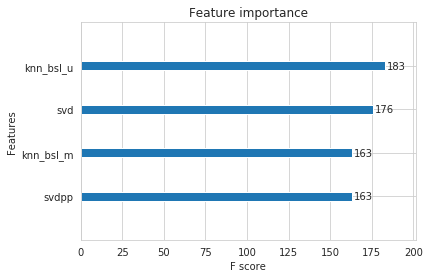

In [56]:
x_train = f_train[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_train = f_train['rating']
x_test = f_test[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_test = f_test['rating']


xgb_all_models = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_all_models, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_eval_train['xgb_all_models'] = train_results
models_eval_test['xgb_all_models'] = test_results

xgb.plot_importance(xgb_all_models)
plt.show()

In [58]:
pd.DataFrame(models_eval_test).to_csv('sample_r.csv')
models = pd.read_csv('sample_r.csv', index_col=0)
models.loc['rmse'].sort_values()

svd               1.0726046873826458
knn_bsl_u         1.0726493739667242
knn_bsl_m          1.072758832653683
svdpp             1.0728491944183447
bsl_algo          1.0730330260516174
xgb_all_models    1.0753047860953797
xgb1               1.076373581778953
xgb_bsl           1.0765603714651855
xgb_knn_um        1.0767793575625662
xgb_knn_bsl       1.0767793575625662
xgb_final         1.0769599573828592
Name: rmse, dtype: object